# Predicting Titanic Survivors

#### Keiti Lo

## Introduction
This data set contains data about the passengers on the Titanic before it sank. I will be predicting passengers' survival using classification trees, based on the data like sex, age, ticket class (pclass), cabin, etc. I will be tuning the classification trees using grid search, cross validation, and learning curves.

In [260]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns        
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

## Reading and preprocessing the data

### Read the data

In [215]:
input_file = "https://raw.githubusercontent.com/grbruns/cst383/master/titanic.csv"
df = pd.read_csv(input_file)

### Preprocessing

In [216]:
# column PassengerId
# a unique numeric passenger ID; not needed
df.drop('PassengerId', axis=1, inplace=True)

# column Cabin
# use only first letter of Cabin
df['Cabin'] = df['Cabin'].str.slice(stop=1)
df['Cabin'].fillna('U', inplace=True)

# column Ticket
# use two categories: tickets containing letters and
# tickets containing only digits
df['Ticket'] = df['Ticket'].str.contains('[a-zA-Z]')

# column Embarked
# hardly any NA embarked values, so drop rows containing them
df.dropna(subset=['Embarked'], inplace=True)

# column Name
# retain only the title of the name, if present
def extract_title(s):
    titles = ['Mr.', 'Mrs.', 'Miss.', 'Master.', 'Dr.']
    for title in titles:
        if title in s:
            return title
    return 'NoTitle'

df['Title'] = df['Name'].apply(extract_title)
df.drop('Name', axis=1, inplace=True)

# column Age
# fill with median value
df['Age'].fillna(df['Age'].median(), inplace=True)

# column Parch (number of parents and children)
# convert from object to numeric
df['Parch'] = df['Parch'].astype(int)

# column Pclass (1, 2, 3)
df['Pclass'] = df['Pclass'].astype(int)

# column Fare
df['Fare'] = df['Fare'].astype(float)

# confirm that no NA values remain
df.isna().mean()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Ticket    889 non-null    object 
 7   Fare      889 non-null    float64
 8   Cabin     889 non-null    object 
 9   Embarked  889 non-null    object 
 10  Title     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.3+ KB


## Initial data exploration

In [198]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,0.382452,2.311586,29.315152,0.524184,0.382452,32.096681
std,0.486260,0.834700,12.984932,1.103705,0.806761,49.697504
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.895800
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


This classification of variables into categorical or numeric looks only at their types.

In [199]:
cat_vars = df.columns[df.dtypes == object].tolist()
print('Categorical variables: {}'.format(cat_vars))

num_vars = df.columns[df.dtypes != object].tolist()
print('Numeric variables: {}'.format(num_vars))

Categorical variables: ['Sex', 'Ticket', 'Cabin', 'Embarked', 'Title']
Numeric variables: ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']


#### Value counts for categorical variables

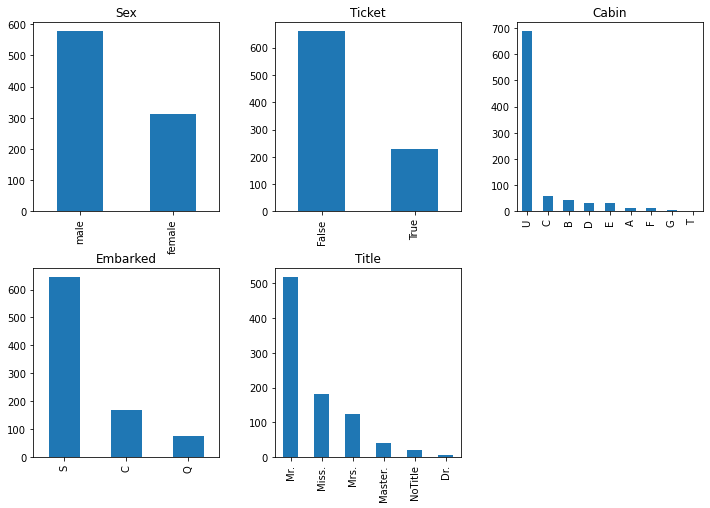

In [200]:
# from our textbook
# https://jakevdp.github.io/PythonDataScienceHandbook/04.08-multiple-subplots.html
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace=0.3, wspace=0.3)   # adjust distance between plots
for i in range(1, len(cat_vars)+1):
    plt.subplot(2, 3, i)
    var = cat_vars[i-1]
    df[var].value_counts().plot.bar()
    plt.title(var);

#### Histograms for numeric variables

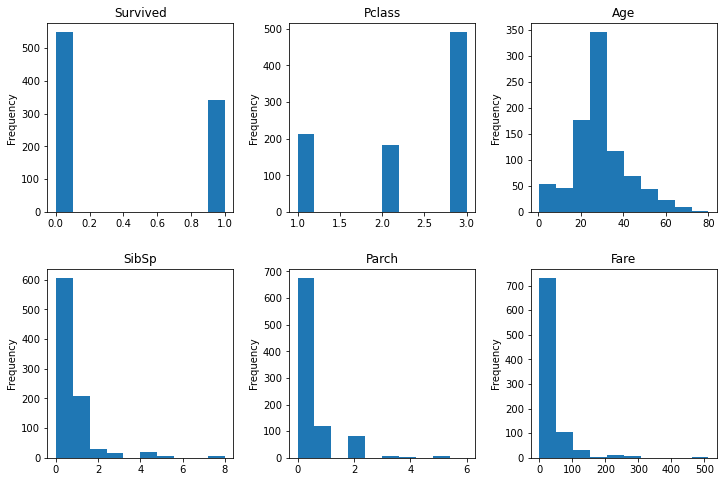

In [201]:
fig = plt.figure(figsize=(12,8))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(1, len(num_vars)+1):
    plt.subplot(2, 3, i)
    var = num_vars[i-1]
    df[var].plot.hist()
    plt.title(var);

From the histograms we can see that variables Survived and Pclass are categorical.  There are only three truly numeric variables in the data set: Age, SibSp, and Parch.  Furthermore, for SibSp and Parch, only a couple of values appear frequently.  It might be useful to convert SibSp and Parch into categorical variables.

## Data exploration

I first want to take a look at how Cabin affects a passenger's possibility for survival. While the description of the data does not specifiy what cabin numbers and letters refer to, I'm assuming that they might stand for the different levels in the ship. I want to see if there is any relation between possible cabin placement with survival rate.

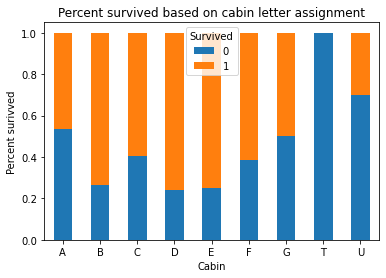

In [202]:
one = pd.crosstab(df['Cabin'], df['Survived'])
one = one.div(df['Cabin'].value_counts(), axis=0)
one.plot.bar(stacked=True).tick_params(labelrotation=0)
plt.xlabel("Cabin")
plt.ylabel("Percent surivved")
plt.title("Percent survived based on cabin letter assignment");

The above graph shows that cabins with letters B, D, and E have higher rates of survival, but that cabin T had 0% chance of survival. I want to quickly look at cabin T to see what other factors might have affected this.

In [203]:
df.loc[df['Cabin']=='T']

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
339,0,1,male,45.0,0,0,False,35.5,T,S,Mr.


Looking up passengers that had a cabin assignment of T showed only one result, which means I can probably disregard cabin T assignment having any significant factor in survival.

I'm not curious to see the relationship between cabin assignment and socio-economic status (Pclass). It would make sense that different classes had separate cabin areas, so I also want to see how those relate and whether or not there might be an affect on survival.

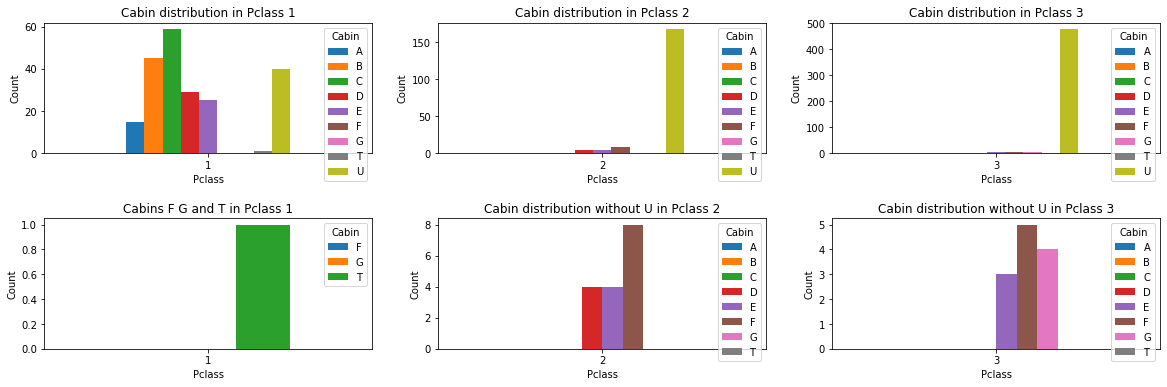

In [204]:
fig,ax = plt.subplots(2,3, figsize=(20,6))
plt.subplots_adjust(hspace=0.5)
a=pd.crosstab(df['Pclass'], df['Cabin'])


b=a[:1].plot.bar(ax=ax[0,0])
b.set_title('Cabin distribution in Pclass 1')
b.set_ylabel('Count')
b.tick_params(labelrotation=0)
c=a[1:2].plot.bar(ax=ax[0,1])
c.set_ylabel('Count')
c.tick_params(labelrotation=0)
c.set_title('Cabin distribution in Pclass 2')
d=a[2:3].plot.bar(ax=ax[0,2])
d.set_ylabel('Count')
d.tick_params(labelrotation=0)
d.set_title('Cabin distribution in Pclass 3')
e=(a[['F','G','T']])[0:1].plot.bar(ax=ax[1,0])
e.tick_params(labelrotation=0)
e.set_ylabel('Count')
e.set_title('Cabins F G and T in Pclass 1')
f=(a.loc[:,a.columns != 'U'])[1:2].plot.bar(ax=ax[1,1])
f.tick_params(labelrotation=0)
f.set_ylabel('Count')
f.set_title('Cabin distribution without U in Pclass 2')
g=(a.loc[:,a.columns != 'U'])[2:3].plot.bar(ax=ax[1,2])
g.tick_params(labelrotation=0)
g.set_ylabel('Count')
g.set_title('Cabin distribution without U in Pclass 3');

The first row shows the different cabin distribution based on class. It looks like classes 2 and 3 both have a majority of passengers in the "U" cabin area, whereas class 1 has a more even distribution. Considering that Pclass 1 passengers are those from high socio-economic background, it makes sense that their cabin area would be different from the majority of the middle and lower class passengers. The second row is just picking out specific cabins to see the count a little more clearly. You can see that the one T cabin is from Pclass 1, and that Pclass 2 and 3 have much less passengers in cabin areas that are not U.

Now I want to take a look at how a passenger's socio-economic status changes their probability of having survived the Titanic, with Pclass of 1=Upper, 2=Middle, and 3=Lower classes.

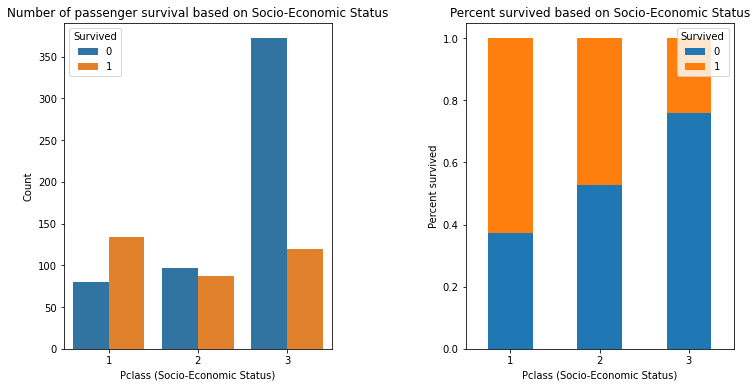

In [179]:
fig,ax = plt.subplots(1,2, figsize=(12,6))
plt.subplots_adjust(wspace=0.5)
a = sns.countplot(x='Pclass', hue='Survived', data=df, ax=ax[0])
a.set_xlabel('Pclass (Socio-Economic Status)')
a.set_ylabel('Count')
a.set_title('Number of passenger survival based on Socio-Economic Status')
b = pd.crosstab(df['Pclass'], df['Survived']).div(df['Pclass'].value_counts(), axis=0).plot.bar(stacked=True,ax=ax[1])
b.set_xlabel('Pclass (Socio-Economic Status)')
b.set_ylabel('Percent survived')
b.tick_params(labelrotation=0)
b.set_title('Percent survived based on Socio-Economic Status');

These graphs show that those who were in a higher socio-economic class had a higher chance of surviving the crash than those in lower socio-economic classes. You can see in the left plot that the number of passengers that survived from a high socio-economic class is higher than the number in either middle or low, and you can see how the lowest class. From the three different visualizations I did with Pclass and Cabin, I beleive that they can both indicate chances of survival well.

I also wanted to take a look at the overall age distribution for those who did and did not survive.

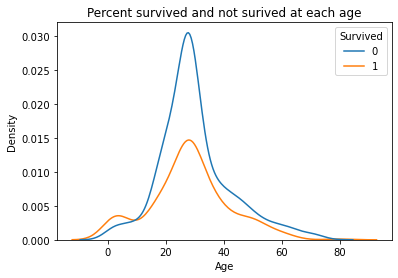

In [222]:
sns.kdeplot(x='Age', hue='Survived', data=df)
plt.title('Percent survived and not surived at each age');

Looking back and comparing this graph with the age histogram, I can see that the huge bump for both survived and not survived passengers at around ages 30-40 is due to a higher number of passengers in that age group. One thing I did notice is that there is a small increase around the 0-10 of higher surviving passengers. From this graph, I can assume that they prioritized getting children off of the sinking Titanic.

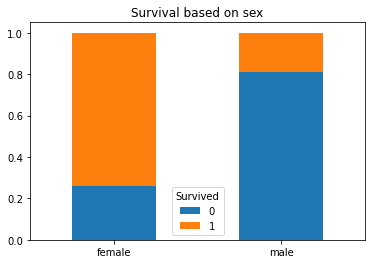

In [223]:
a = pd.crosstab(df['Sex'], df['Survived'])
a = a.div(df['Sex'].value_counts(), axis=0)
a.plot.bar(stacked=True).tick_params(labelrotation=0)
plt.title('Survival based on sex');

Here you can also see that there is a much higher chance of survival for females, at ~72%, whereas it was only ~20% for males. Based on the age and sex, I believe they evacuated the ship with children and women as priority. I believe that sex and age will also be very good predictors of survival.

## Building a classification tree

In [317]:
np.random.seed(123)

I'm going to convert categorical variables to numeric variables using ordinal encoding

In [374]:
from sklearn.preprocessing import LabelEncoder
df['Sex'] = LabelEncoder().fit_transform(df['Sex'])
df['Ticket'] = LabelEncoder().fit_transform(df['Ticket'])
df['Cabin'] = LabelEncoder().fit_transform(df['Cabin'])
df['Embarked'] = LabelEncoder().fit_transform(df['Embarked'])
df['Title'] = LabelEncoder().fit_transform(df['Title'])

Now I will pick my predictors, create the test train split, train the model, and visualizing the tree.

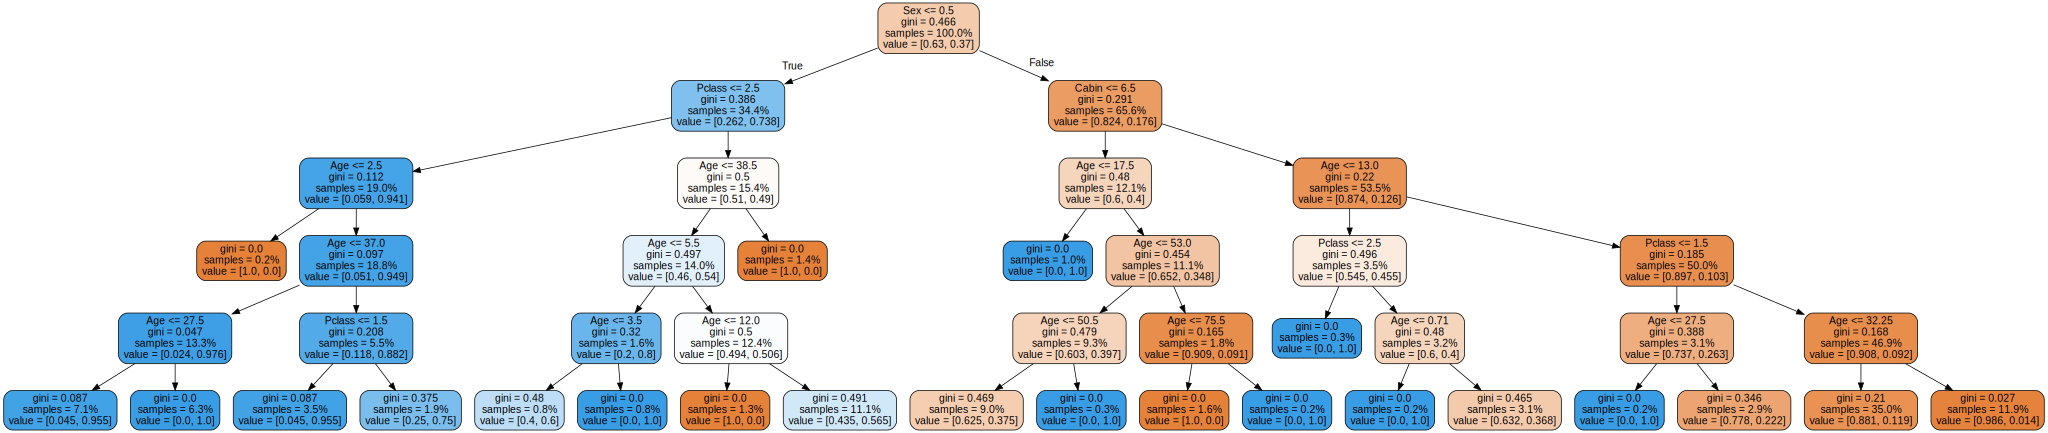

In [375]:
predictors = ['Cabin', 'Pclass', 'Age', 'Sex']
X = df[predictors].values
y = df['Survived'].values

# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# train the tree model
clf = DecisionTreeClassifier(max_depth=5, random_state=0)
clf.fit(X_train, y_train)

target_names=['Yes', 'No']
data = export_graphviz(clf,feature_names=predictors,filled=True, rounded=True, proportion=True)
graph = graphviz.Source(data)
graph

## Making predictions and assessing your model

First I want to get the blind prediction and baseline accuracy so I know what to compare to when tuning my machine learning algorithm.

In [376]:
blind_prediction=np.median(y_train) # with binary target variable, the most common value is also the median value
print("Baseline accuracy: {:.2f}".format((blind_prediction == y_test).mean()))

Baseline accuracy: 0.59


I will get predictions from my initial model and get accuracy and the confusion matrix.

In [377]:
y_predict = clf.predict(X_test)

print("Initial test accuracy: {:.2f}".format((y_predict == y_test).mean()))
pd.crosstab(y_test, columns=y_predict, colnames=['Predicted'], rownames=['Actual'])

Initial test accuracy: 0.78


Predicted,0,1
Actual,,
0,132,25
1,33,77


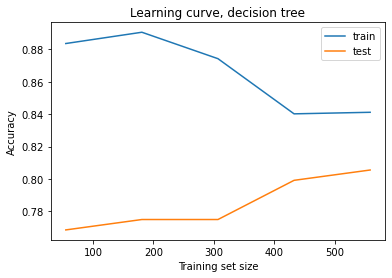

In [378]:
train_sizes, train_scores, test_scores = learning_curve(clf, X_train, y_train, cv=10, scoring='accuracy')
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='train')
plt.plot(train_sizes, test_scores_mean, label='test')
plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.title('Learning curve, decision tree')
plt.legend();

There is a large gap between the two curves with average to low training error. The large gap between the curves typically means that this is a high variance situation and that my model is overfitting. 

In [379]:
# train the tree model
clf2 = DecisionTreeClassifier(max_depth=4, random_state=0)
clf2.fit(X_train, y_train)

y_predict2 = clf2.predict(X_test)
print("Test accuracy: {:.2f}".format((y_predict2 == y_test).mean()))
pd.crosstab(y_test, columns=y_predict2, colnames=['Predicted 2'], rownames=['Actual'])

Test accuracy: 0.79


Predicted 2,0,1
Actual,,
0,134,23
1,33,77


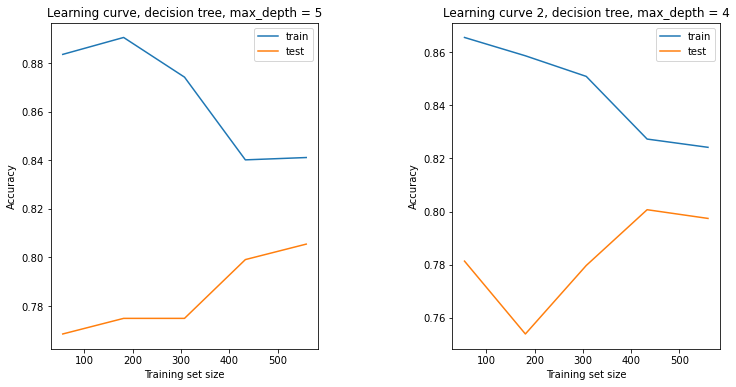

In [380]:
train_sizes2, train_scores2, test_scores2 = learning_curve(clf2, X_train, y_train, cv=10, scoring='accuracy')
train_scores_mean2 = np.mean(train_scores2, axis=1)
test_scores_mean2 = np.mean(test_scores2, axis=1)
fig,ax = plt.subplots(1,2, figsize=(12,6))
plt.subplots_adjust(wspace=0.5)
ax[1].plot(train_sizes2, train_scores_mean2, label='train')
ax[1].plot(train_sizes2, test_scores_mean2, label='test')
ax[1].set_xlabel('Training set size')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Learning curve 2, decision tree, max_depth = 4')
ax[1].legend()
ax[0].plot(train_sizes, train_scores_mean, label='train')
ax[0].plot(train_sizes, test_scores_mean, label='test')
ax[0].set_xlabel('Training set size')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Learning curve, decision tree, max_depth = 5')
ax[0].legend();

Honestly, I'm very confused. I tried decreasing max_depth from 5, but other than changing it to 4, the other numbers lowered my test accuracy and made the test learning curve have a few very low spots. Just to cover all bases, I also tried increasing max_depth, and got improvements in test accuracy from values of 6,8,and 9. However, increasing the max_depth definitely made my model overfit, and the training accuracy was extremely high. After comparing the different depths myself, I decided that keeping max_depth=4 was the best in terms of improving test accuracy and lowering overfitting.

## Tuning the model

_Use grid search with cross validation to tune your model and increase its accuracy._

In [396]:
grid={
    "max_depth":range(1,10),
}

gridSearch = GridSearchCV(DecisionTreeClassifier(random_state=0), grid, cv=10, scoring='accuracy')
gridSearch.fit(X_train, y_train)

gridSearch.best_params_

{'max_depth': 3}

Turns out my eyeing the graphs was inaccurate and the best max_depth is 3. 

## Test accuracy of best model

In [398]:
best = gridSearch.best_estimator_
best.fit(X_train, y_train)
# train the tree model
clf2 = DecisionTreeClassifier(max_depth=4, random_state=0)
clf2.fit(X_train, y_train)

y_predict2 = clf2.predict(X_test)
print("Test accuracy: {:.2f}".format((y_predict2 == y_test).mean()))
pd.crosstab(y_test, columns=y_predict2, colnames=['Predicted 2'], rownames=['Actual'])

## Conclusions

_Say a little here about your results.  For example, what test accuracy did you achieve?  What was the baseline accuracy?  Which predictors were most important? These are only examples._

The highest test accuracy I ended up achieving was 0.79 while my baseline accuracy was 0.59. 